# Bullseye Cavity Surrogate

In [4]:
# Uncomment the following line to install pyswarms if it's not installed in your environment already
# pip install pyswarms

# Standard python imports
import numpy as np
import matplotlib.pylab as plt

# Import regular tidy3d
import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd

In [5]:
# Initial parameters of the Bullseye cavity.
t_tio2 = 0.200  # TiO2 thin film thickness (um).
t_sio2 = 0.435  # SiO2 thin film thickness (um).
r_cav = 0.835  # Radius of the internal cavity (um).
p_bragg = 0.420  # Period of the Bragg reflector (um).
w_bragg = 0.155  # Gap width (etched region) of the Bragg reflector (um).
n_bragg = 8  # Number of Bragg periods.
n_tio2 = 2.50  # TiO2 refractive index (0.75 um).
n_sio2 = 1.45  # SiO2 refractive index (0.75 um).

# Collection fiber parameters (630HP).
r_core = 1.75  # Fiber core radius.
n_core = 1.46  # Core refractive index.
n_clad = 1.45  # Cladding refractive index.
d_cf = 2.0  # Distance between the cavity and the fiber.

# PSO optimization parameters.
iterations = 15  # Number of iterations.
n_particle = 5  # Number of particles in optimization.

# Simulation wavelength.
wl = 0.75  # Central simulation wavelength (um).
bw = 0.06  # Simulation bandwidth (um).
n_wl = 61  # Number of wavelength points within the bandwidth.

In [6]:
# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 5e-12  # Simulation run time.

# Material definition.
mat_tio2 = td.Medium(permittivity=n_tio2 ** 2)  # TiO2 medium.
mat_sio2 = td.Medium(permittivity=n_sio2 ** 2)  # SiO2 medium.
mat_etch = td.Medium(permittivity=1)  # Etch medium.
mat_core = td.Medium(permittivity=n_core ** 2)  # Fiber core medium.
mat_clad = td.Medium(permittivity=n_clad ** 2)  # Fiber cladding medium.

# Computational domain size.
pml_spacing = 0.6 * wl
eff_inf = 10

In [7]:
def get_simulation(
    r: float = r_cav,  # Cavity radius.
    p: float = p_bragg,  # Cavity period.
    w: float = w_bragg,  # Etched width.
    h: float = 0.0,  # Non-etched thickness with respect to TiO2 thickness.
    tsio2: float = t_sio2,  # SiO2 layer thickness.
    dcf: float = d_cf,  # Cavity to fiber distance.
) -> td.Simulation:
    """Create a Simulation of a bullseye cavity with variable geometry and material thickness."""

    # Computational domain size.
    size_x = 2 * pml_spacing + max(2 * (r + n_bragg * p), 2 * r_core)
    size_y = size_x
    size_z = pml_spacing + tsio2 + t_tio2 + dcf
    center_z = -size_z / 2
    qd_pos_z = tsio2 + t_tio2
    mon_pos_z = size_z - pml_spacing / 2

    # Point dipole source located at the center of TiO2 thin film.
    dp_source = td.PointDipole(
        center=(0, 0, qd_pos_z),
        source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
        polarization="Ey",
    )

    # Field monitor to visualize the fields in xy plane.
    field_monitor_xy = td.FieldMonitor(
        center=(0, 0, qd_pos_z - t_tio2 / 2),
        size=(size_x, size_y, 0),
        freqs=[freq],
        name="field_xy",
    )

    # Field monitor to visualize the fields in xz plane.
    field_monitor_xz = td.FieldMonitor(
        center=(0, 0.05, size_z / 2),
        size=(size_x, 0, size_z),
        freqs=[freq],
        name="field_xz",
    )

    # Mode monitor to get the power coupled into the fiber modes.
    mode_spec = td.ModeSpec(num_modes=1, target_neff=n_core)
    mode_monitor = td.ModeMonitor(
        center=(0, 0, mon_pos_z),
        size=(size_x, size_y, 0),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode_fiber",
    )

    # Flux monitor to get the total dipole power.
    flux_dip = td.FluxMonitor(
        center=(0, 0, size_z / 2),
        size=(0.8*size_x, 0.8*size_y, size_z),
        freqs=freqs,
        exclude_surfaces=("z-",),
        name="flux_dip",
    )

    # Silicon dioxide layer
    sio2_layer = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, -eff_inf),
            rmax=(size_x / 2 + eff_inf, size_y / 2 + eff_inf, tsio2),
        ),
        medium=mat_sio2,
    )

    # Fiber cladding
    fiber_clad = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, size_z - pml_spacing),
            rmax=(size_x / 2 + eff_inf, size_y / 2 + eff_inf, size_z + eff_inf),
        ),
        medium=mat_clad,
    )

    # Fiber core
    fiber_core = td.Structure(
        geometry=td.Cylinder(
            radius=r_core,
            center=(0, 0, size_z + (((pml_spacing + eff_inf) / 2) - pml_spacing)),
            axis=2,
            length=pml_spacing + eff_inf,
        ),
        medium=mat_core,
    )

    # Bullseye cavity
    bullseye = []
    cyl_rad = n_bragg * p + r
    for _ in range(0, n_bragg):
        bullseye.append(
            td.Structure(
                geometry=td.Cylinder(
                    radius=cyl_rad,
                    center=(0, 0, qd_pos_z - t_tio2 / 2),
                    axis=2,
                    length=t_tio2,
                ),
                medium=mat_tio2,
            )
        )
        bullseye.append(
            td.Structure(
                geometry=td.Cylinder(
                    radius=cyl_rad - p + w,
                    center=(0, 0, qd_pos_z - t_tio2 / 2),
                    axis=2,
                    length=t_tio2,
                ),
                medium=mat_etch,
            )
        )
        cyl_rad -= p

    bullseye.append(
        td.Structure(
            geometry=td.Cylinder(
                radius=r, center=(0, 0, qd_pos_z - t_tio2 / 2), axis=2, length=t_tio2
            ),
            medium=mat_tio2,
        )
    )
    # Non-etched TiO2 region.
    if h > 0:
        bullseye.append(
            td.Structure(
                geometry=td.Box.from_bounds(
                    rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, tsio2),
                    rmax=(
                        size_x / 2 + eff_inf,
                        size_y / 2 + eff_inf,
                        tsio2 + h * t_tio2,
                    ),
                ),
                medium=mat_tio2,
            )
        )

    # Simulation definition
    sim = td.Simulation(
        center=(0, 0, -center_z),
        size=(size_x, size_y, size_z),
        medium=mat_etch,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=wl),
        structures=[sio2_layer, fiber_clad, fiber_core] + bullseye,
        sources=[dp_source],
        normalize_index=0,
        monitors=[field_monitor_xy, field_monitor_xz, mode_monitor, flux_dip],
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(),
            y=td.Boundary.pml(),
            z=td.Boundary(minus=td.PECBoundary(), plus=td.PML()),
        ),
        symmetry=(1, -1, 0),
        run_time=run_time,
    )
    return sim

In [8]:
# Figure of Merit (FOM) calculation.
def get_coupling_eff(sim_data: td.SimulationData) -> float:
    """Return the power at the mode index of interest."""
    mode_amps = sim_data["mode_fiber"].amps.sel(direction="+", mode_index=0)
    mode_power = np.squeeze(np.abs(mode_amps) ** 2)
    dip_power = sim_data["flux_dip"].flux
    return mode_power / dip_power

In [9]:
def fn_pre(r: float, p: float, w: float, h: float, t_sio2: float, dcf: float) -> td.Simulation:
    """Build a Simulation object from parameters suggested by the PSO."""
    sim = get_simulation(r, p, w, h, t_sio2, dcf)
    return sim

def fn_post(sim_data: td.SimulationData) -> float:
    """Analyze SimulationData from a bullseye cavity simulation and return coupling efficiency."""
    ce = np.max(get_coupling_eff(sim_data))
    return float(ce)

In [36]:
# Setup parameters for DesignSpace
r_param = tdd.ParameterFloat(name="r", span=(0.5 * r_cav, 1.5 * r_cav))
p_param = tdd.ParameterFloat(name="p", span=(0.5 * p_bragg, 1.5 * p_bragg))
w_param = tdd.ParameterFloat(name="w", span=(0.5 * w_bragg, 1.5 * w_bragg))
h_param = tdd.ParameterFloat(name="h", span=(0.0, 1.0))
t_sio2_param = tdd.ParameterFloat(name="t_sio2", span=(0.5 * t_sio2, 1.5 * t_sio2))
dcf_param = tdd.ParameterFloat(name="dcf", span=(0.5 * d_cf, 1.5 * d_cf))
parameters = [r_param, p_param, w_param, h_param, t_sio2_param, dcf_param]

monte_carlo=tdd.MethodMonteCarlo(
    num_points=100,
    seed=2,
)

design_space = tdd.DesignSpace(method=monte_carlo, parameters=parameters, task_name="BE_MC_Surrogate", path_dir="/home/matt/Documents/Flexcompute/bullseye/data")

In [11]:
# Run the MC
results = design_space.run(fn_pre, fn_post, verbose=True)
df = results.to_dataframe()

12:12:21 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

12:12:22 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             Running 100 Simulations

12:12:23 BST WARNING: Mode monitor 'mode_fiber' has a large number (1.87e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.85e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.51e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.30e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Mode monitor 'mode_fiber' has a large number (2.40e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (3.97e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (4.17e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.68e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.04e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:25 BST WARNING: Mode monitor 'mode_fiber' has a large number (1.92e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:26 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (2.44e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.46e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.44e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (4.30e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (4.10e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.72e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.06e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.60e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.63e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:27 BST WARNING: Mode monitor 'mode_fiber' has a large number (3.87e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.34e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.23e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:28 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (3.02e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.37e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.83e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.11e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.34e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.29e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.32e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:29 BST WARNING: Mode monitor 'mode_fiber' has a large number (2.54e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.57e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.30e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.00e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.89e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.06e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (4.41e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.71e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.55e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:30 BST WARNING: Mode monitor 'mode_fiber' has a large number (3.27e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.32e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.36e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

12:12:31 BST WARNING: Mode monitor 'mode_fiber' has a large number (1.54e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.22e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.97e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.79e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.28e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.20e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.89e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (4.25e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:32 BST WARNING: Mode monitor 'mode_fiber' has a large number (3.46e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.58e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.65e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:33 BST WARNING: Mode monitor 'mode_fiber' has a large number (1.09e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.58e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.32e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (4.02e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.44e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.99e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.50e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (2.19e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.24e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:34 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (1.49e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.80e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:35 BST WARNING: Suppressed 1 WARNING message.                             

             WARNING: Mode monitor 'mode_fiber' has a large number (3.72e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.83e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.36e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.62e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Mode monitor 'mode_fiber' has a large number (3.65e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (4.54e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:36 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (2.64e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.50e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.89e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.47e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.25e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.16e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.27e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Suppressed 1 WARNING message.                             

             WARNING: Mode monitor 'mode_fiber' has a large number (2.19e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:37 BST WARNING: Mode monitor 'mode_fiber' has a large number (3.77e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.87e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:38 BST WARNING: Mode monitor 'mode_fiber' has a large number (3.53e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (1.92e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.60e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.40e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Mode monitor 'mode_fiber' has a large number (2.12e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (3.70e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.08e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.85e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.68e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:12:39 BST WARNING: Mode monitor 'mode_fiber' has a large number (1.87e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.06e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.97e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (2.81e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             WARNING: Mode monitor 'mode_fiber' has a large number (1.13e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

12:22:01 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

12:22:03 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

12:22:05 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

12:22:07 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

12:22:11 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

12:22:16 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

             WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

12:22:19 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

12:22:21 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

12:22:22 BST WARNING: A structure has a nonzero dimension along axis z, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

In [22]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/bullseye/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

In [ ]:
# Get ce across the range
ce = []
for task_path in results.task_paths:
    sim_data = td.SimulationData.from_hdf5(task_path)
    ce.append(get_coupling_eff(sim_data))

## Surrogate

In [25]:
# Expand the array by each frequency value
df["ce"] = ce
df_expand = df.explode("ce").reset_index(drop=True)
df_expand["freq"] = df_expand["ce"].apply(lambda x: float(x.f))
df_expand["ce"] = df_expand["ce"].apply(lambda x: float(x))


# df_expanded_t1 = df.explode("T1").reset_index(drop=True)
# df_expanded_t2 = df.explode("T2").reset_index(drop=True)
# df_expanded_t1["freq"] = df_expanded_t1["T1"].apply(lambda x: float(x.f))
# df_expanded_t1["T2"] = df_expanded_t2["T2"].apply(lambda x: float(x))
# df_expanded_t1["T1"] = df_expanded_t1["T1"].apply(lambda x: float(x))

# expanded_df = df_expanded_t1

# Some shit to get couple eff and Purcell

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/bullseye"
data_dir = ["/home/matt/Documents/Flexcompute/bullseye/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 64
epochs = 100

trial_count = 20

model = AI_Model(output_dir, data_dir, seed=1)

model.load_data_from_df(
    df=df_expand,
    label_names=["ce"],
    feature_names=["r", "p", "w", "h", "t_sio2", "dcf", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True
)

loss_fn = nn.MSELoss()


Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


In [30]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 1))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Using existing directory at Model1


  2%|▏         | 2/100 [00:00<00:06, 15.15it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2


  4%|▍         | 4/100 [00:00<00:05, 17.36it/s]

Best State Updated. Epoch: 3


  6%|▌         | 6/100 [00:00<00:05, 16.18it/s]

Best State Updated. Epoch: 4
Best State Updated. Epoch: 5
Best State Updated. Epoch: 6


  9%|▉         | 9/100 [00:00<00:05, 18.08it/s]

Best State Updated. Epoch: 7


 11%|█         | 11/100 [00:00<00:04, 17.83it/s]

Best State Updated. Epoch: 9


 13%|█▎        | 13/100 [00:00<00:04, 17.84it/s]

Best State Updated. Epoch: 11
Best State Updated. Epoch: 12


 15%|█▌        | 15/100 [00:00<00:04, 17.75it/s]

Best State Updated. Epoch: 14


 17%|█▋        | 17/100 [00:00<00:04, 17.28it/s]

Best State Updated. Epoch: 15
Best State Updated. Epoch: 17


 19%|█▉        | 19/100 [00:01<00:04, 18.02it/s]

Best State Updated. Epoch: 18


 21%|██        | 21/100 [00:01<00:04, 17.39it/s]

Best State Updated. Epoch: 19
Best State Updated. Epoch: 21


 26%|██▌       | 26/100 [00:01<00:04, 18.21it/s]

Best State Updated. Epoch: 22
Best State Updated. Epoch: 23
Best State Updated. Epoch: 24
Best State Updated. Epoch: 25
Best State Updated. Epoch: 26


 31%|███       | 31/100 [00:01<00:03, 19.31it/s]

Best State Updated. Epoch: 27
Best State Updated. Epoch: 28
Best State Updated. Epoch: 29
Best State Updated. Epoch: 30
Best State Updated. Epoch: 31


 36%|███▌      | 36/100 [00:01<00:03, 20.13it/s]

Best State Updated. Epoch: 32
Best State Updated. Epoch: 34


 41%|████      | 41/100 [00:02<00:03, 18.77it/s]

Best State Updated. Epoch: 37
Best State Updated. Epoch: 39
Best State Updated. Epoch: 40


 45%|████▌     | 45/100 [00:02<00:03, 18.24it/s]

Best State Updated. Epoch: 41
Best State Updated. Epoch: 43


 48%|████▊     | 48/100 [00:02<00:02, 18.94it/s]

Best State Updated. Epoch: 45
Best State Updated. Epoch: 46
Best State Updated. Epoch: 49


 53%|█████▎    | 53/100 [00:02<00:02, 18.90it/s]

Best State Updated. Epoch: 50
Best State Updated. Epoch: 53


 56%|█████▌    | 56/100 [00:03<00:02, 19.51it/s]

Best State Updated. Epoch: 54


 71%|███████   | 71/100 [00:03<00:01, 19.46it/s]

Best State Updated. Epoch: 67


 79%|███████▉  | 79/100 [00:04<00:01, 20.49it/s]

Best State Updated. Epoch: 76
Best State Updated. Epoch: 79


 93%|█████████▎| 93/100 [00:04<00:00, 20.83it/s]

Best State Updated. Epoch: 88


 99%|█████████▉| 99/100 [00:05<00:00, 19.21it/s]

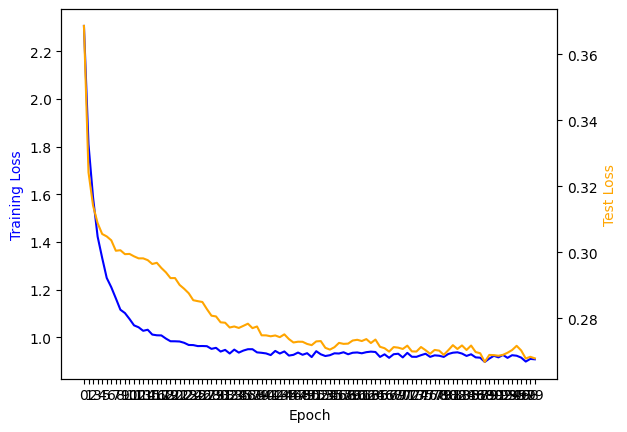

100%|██████████| 100/100 [00:05<00:00, 18.44it/s]

 Best Test Loss: 0.2667745053768158
RMSE: 0.036202
MAE: 0.024547


In [31]:
# Create single model
network = VariableANN(7, [4, 4, 4], 0.2)
opt = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

trained_net = model.train_model("Model1", network, opt, loss_fn, epochs, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

[I 2024-08-22 14:02:23,147] A new study created in memory with name: no-name-053265b4-ed69-470b-8a33-90eb362c3896


Making temp model folder


100%|██████████| 100/100 [00:06<00:00, 16.53it/s]
[I 2024-08-22 14:02:29,211] Trial 0 finished with value: 0.033077 and parameters: {'dropout': 0.2, 'neurons0': 192, 'neurons1': 16, 'neurons2': 80, 'neurons3': 48, 'neurons4': 32, 'lr': 5.5595654267125665e-05, 'weight_decay': 4.9104518184659654e-05}. Best is trial 0 with value: 0.033077.


 Best Test Loss: 0.22131243348121643
RMSE: 0.033077
MAE: 0.022237
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.28it/s]
[I 2024-08-22 14:02:35,364] Trial 1 finished with value: 0.035378 and parameters: {'dropout': 0.2, 'neurons0': 144, 'neurons1': 112, 'neurons2': 176, 'neurons3': 64, 'neurons4': 240, 'lr': 1.2869165107815022e-05, 'weight_decay': 0.00021924768698806357}. Best is trial 0 with value: 0.033077.


 Best Test Loss: 0.2520836293697357
RMSE: 0.035378
MAE: 0.023674
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 15.90it/s]
[I 2024-08-22 14:02:41,663] Trial 2 finished with value: 0.01986 and parameters: {'dropout': 0.2, 'neurons0': 144, 'neurons1': 48, 'neurons2': 64, 'neurons3': 208, 'neurons4': 256, 'lr': 0.00017934807211789802, 'weight_decay': 0.00024246286430387818}. Best is trial 2 with value: 0.01986.


 Best Test Loss: 0.07788965106010437
RMSE: 0.01986
MAE: 0.013231
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]
[I 2024-08-22 14:02:47,763] Trial 3 finished with value: 0.037447 and parameters: {'dropout': 0.45, 'neurons0': 240, 'neurons1': 32, 'neurons2': 16, 'neurons3': 48, 'neurons4': 240, 'lr': 2.473929591304018e-05, 'weight_decay': 6.953688788898672e-05}. Best is trial 2 with value: 0.01986.


 Best Test Loss: 0.28670045733451843
RMSE: 0.037447
MAE: 0.025783
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.22it/s]
[I 2024-08-22 14:02:53,941] Trial 4 finished with value: 0.038451 and parameters: {'dropout': 0.5, 'neurons0': 144, 'neurons1': 192, 'neurons2': 96, 'neurons3': 176, 'neurons4': 224, 'lr': 1.183458707441061e-05, 'weight_decay': 0.00031643799922388406}. Best is trial 2 with value: 0.01986.


 Best Test Loss: 0.3031437397003174
RMSE: 0.038451
MAE: 0.026214
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.56it/s]
[I 2024-08-22 14:02:59,988] Trial 5 finished with value: 0.038734 and parameters: {'dropout': 0.5, 'neurons0': 192, 'neurons1': 80, 'neurons2': 208, 'neurons3': 32, 'neurons4': 128, 'lr': 0.04309054751874313, 'weight_decay': 3.8657013301325196e-05}. Best is trial 2 with value: 0.01986.


 Best Test Loss: 0.3075864315032959
RMSE: 0.038734
MAE: 0.026965
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.20it/s]
[I 2024-08-22 14:03:06,172] Trial 6 finished with value: 0.017209 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 48, 'neurons1': 16, 'neurons2': 176, 'neurons3': 64, 'neurons4': 80, 'lr': 0.0009253214657642581, 'weight_decay': 1.2785717080546074e-05}. Best is trial 6 with value: 0.017209.


 Best Test Loss: 0.05886761099100113
RMSE: 0.017209
MAE: 0.011244
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:05<00:00, 16.95it/s]
[I 2024-08-22 14:03:12,080] Trial 7 finished with value: 0.038733 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 48, 'neurons1': 160, 'neurons2': 192, 'neurons3': 32, 'neurons4': 112, 'lr': 0.005992397731141758, 'weight_decay': 6.735324727887574e-05}. Best is trial 6 with value: 0.017209.


 Best Test Loss: 0.30756479501724243
RMSE: 0.038733
MAE: 0.026848
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:05<00:00, 17.56it/s]
[I 2024-08-22 14:03:17,787] Trial 8 finished with value: 0.034193 and parameters: {'dropout': 0.0, 'neurons0': 144, 'neurons1': 176, 'neurons2': 144, 'neurons3': 256, 'neurons4': 160, 'lr': 0.04107784588077006, 'weight_decay': 1.883429672763721e-05}. Best is trial 6 with value: 0.017209.


 Best Test Loss: 0.23255525529384613
RMSE: 0.034193
MAE: 0.023163
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.36it/s]
[I 2024-08-22 14:03:23,909] Trial 9 finished with value: 0.038733 and parameters: {'dropout': 0.05, 'neurons0': 208, 'neurons1': 112, 'neurons2': 48, 'neurons3': 240, 'neurons4': 96, 'lr': 0.010075077894785215, 'weight_decay': 0.00028313657268211513}. Best is trial 6 with value: 0.017209.


 Best Test Loss: 0.3075679540634155
RMSE: 0.038733
MAE: 0.026804
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:05<00:00, 16.68it/s]
[I 2024-08-22 14:03:29,928] Trial 10 finished with value: 0.035233 and parameters: {'dropout': 0.1, 'neurons0': 32, 'neurons1': 256, 'neurons2': 256, 'neurons3': 112, 'neurons4': 48, 'lr': 0.0008170112233606854, 'weight_decay': 0.0009700201070951772}. Best is trial 6 with value: 0.017209.


 Best Test Loss: 0.2521897256374359
RMSE: 0.035233
MAE: 0.023613
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.52it/s]
[I 2024-08-22 14:03:36,004] Trial 11 finished with value: 0.016352 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 80, 'neurons1': 64, 'neurons2': 112, 'neurons3': 176, 'neurons4': 192, 'lr': 0.00030114614593710655, 'weight_decay': 1.0249141173809982e-05}. Best is trial 11 with value: 0.016352.


 Best Test Loss: 0.053996700793504715
RMSE: 0.016352
MAE: 0.011277
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.43it/s]
[I 2024-08-22 14:03:42,113] Trial 12 finished with value: 0.015998 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 80, 'neurons1': 64, 'neurons2': 128, 'neurons3': 128, 'neurons4': 176, 'lr': 0.0006095525865948753, 'weight_decay': 1.2181979705212937e-05}. Best is trial 12 with value: 0.015998.


 Best Test Loss: 0.050856102257966995
RMSE: 0.015998
MAE: 0.011083
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.46it/s]
[I 2024-08-22 14:03:48,210] Trial 13 finished with value: 0.019936 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 96, 'neurons1': 80, 'neurons2': 128, 'neurons3': 144, 'neurons4': 176, 'lr': 0.00020357735816785424, 'weight_decay': 1.041482069293323e-05}. Best is trial 12 with value: 0.015998.


 Best Test Loss: 0.07829782366752625
RMSE: 0.019936
MAE: 0.013609
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.49it/s]
[I 2024-08-22 14:03:54,296] Trial 14 finished with value: 0.020954 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 80, 'neurons1': 64, 'neurons2': 128, 'neurons3': 112, 'neurons4': 192, 'lr': 0.003223512352176769, 'weight_decay': 2.674289930704896e-05}. Best is trial 12 with value: 0.015998.


 Best Test Loss: 0.0868239477276802
RMSE: 0.020954
MAE: 0.014416
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.10it/s]
[I 2024-08-22 14:04:00,529] Trial 15 finished with value: 0.018762 and parameters: {'dropout': 0.4, 'neurons0': 96, 'neurons1': 112, 'neurons2': 112, 'neurons3': 160, 'neurons4': 208, 'lr': 0.00024807582738433986, 'weight_decay': 2.1419117725299177e-05}. Best is trial 12 with value: 0.015998.


 Best Test Loss: 0.07222501188516617
RMSE: 0.018762
MAE: 0.012796
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 15.95it/s]
[I 2024-08-22 14:04:06,820] Trial 16 finished with value: 0.025206 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 16, 'neurons1': 144, 'neurons2': 144, 'neurons3': 192, 'neurons4': 160, 'lr': 0.0016545364821838528, 'weight_decay': 1.0602980650023242e-05}. Best is trial 12 with value: 0.015998.


 Best Test Loss: 0.12485238164663315
RMSE: 0.025206
MAE: 0.018297
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.04it/s]
[I 2024-08-22 14:04:13,076] Trial 17 finished with value: 0.029541 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 80, 'neurons1': 64, 'neurons2': 224, 'neurons3': 112, 'neurons4': 144, 'lr': 7.78945766915267e-05, 'weight_decay': 0.00010645853260179363}. Best is trial 12 with value: 0.015998.


 Best Test Loss: 0.17785799503326416
RMSE: 0.029541
MAE: 0.019064
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:06<00:00, 16.08it/s]
[I 2024-08-22 14:04:19,319] Trial 18 finished with value: 0.01531 and parameters: {'dropout': 0.4, 'neurons0': 112, 'neurons1': 96, 'neurons2': 160, 'neurons3': 208, 'neurons4': 192, 'lr': 0.0005150050983960436, 'weight_decay': 3.1022252129819e-05}. Best is trial 18 with value: 0.01531.


 Best Test Loss: 0.047142982482910156
RMSE: 0.01531
MAE: 0.010559
Making temp model folder
Using existing directory at temp


100%|██████████| 100/100 [00:05<00:00, 16.74it/s]
[I 2024-08-22 14:04:25,317] Trial 19 finished with value: 0.035808 and parameters: {'dropout': 0.4, 'neurons0': 128, 'neurons1': 208, 'neurons2': 160, 'neurons3': 224, 'neurons4': 208, 'lr': 0.012801733638169562, 'weight_decay': 3.165352957487329e-05}. Best is trial 18 with value: 0.01531.


 Best Test Loss: 0.2578393816947937
RMSE: 0.035808
MAE: 0.024264
Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  0
  Number of complete trials:  20
Best trial:
  Value:  0.01531
  Params: 
    dropout: 0.4
    neurons0: 112
    neurons1: 96
    neurons2: 160
    neurons3: 208
    neurons4: 192
    lr: 0.0005150050983960436
    weight_decay: 3.1022252129819e-05
Using existing directory at Model1


  0%|          | 2/1000 [00:00<01:14, 13.36it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2


  0%|          | 4/1000 [00:00<01:14, 13.41it/s]

Best State Updated. Epoch: 3
Best State Updated. Epoch: 4


  1%|          | 6/1000 [00:00<01:11, 13.99it/s]

Best State Updated. Epoch: 5


  1%|          | 8/1000 [00:00<01:15, 13.20it/s]

Best State Updated. Epoch: 6
Best State Updated. Epoch: 7


  1%|          | 10/1000 [00:00<01:09, 14.17it/s]

Best State Updated. Epoch: 8
Best State Updated. Epoch: 9


  1%|          | 12/1000 [00:00<01:05, 14.99it/s]

Best State Updated. Epoch: 10
Best State Updated. Epoch: 11
Best State Updated. Epoch: 12


  2%|▏         | 16/1000 [00:01<01:08, 14.36it/s]

Best State Updated. Epoch: 13
Best State Updated. Epoch: 14
Best State Updated. Epoch: 15
Best State Updated. Epoch: 16


  2%|▏         | 20/1000 [00:01<01:02, 15.57it/s]

Best State Updated. Epoch: 17
Best State Updated. Epoch: 18
Best State Updated. Epoch: 19
Best State Updated. Epoch: 20


  2%|▏         | 24/1000 [00:01<01:00, 16.07it/s]

Best State Updated. Epoch: 21
Best State Updated. Epoch: 22
Best State Updated. Epoch: 23
Best State Updated. Epoch: 24


  3%|▎         | 26/1000 [00:01<01:03, 15.32it/s]

Best State Updated. Epoch: 25
Best State Updated. Epoch: 26


  3%|▎         | 32/1000 [00:02<01:03, 15.25it/s]

Best State Updated. Epoch: 28
Best State Updated. Epoch: 30
Best State Updated. Epoch: 31


  3%|▎         | 34/1000 [00:02<01:04, 14.98it/s]

Best State Updated. Epoch: 32
Best State Updated. Epoch: 33


  4%|▍         | 38/1000 [00:02<01:09, 13.80it/s]

Best State Updated. Epoch: 35
Best State Updated. Epoch: 37


  4%|▍         | 42/1000 [00:02<01:04, 14.93it/s]

Best State Updated. Epoch: 38
Best State Updated. Epoch: 39
Best State Updated. Epoch: 40
Best State Updated. Epoch: 41


  5%|▍         | 46/1000 [00:03<01:03, 14.95it/s]

Best State Updated. Epoch: 42
Best State Updated. Epoch: 43
Best State Updated. Epoch: 45


  5%|▌         | 50/1000 [00:03<01:00, 15.73it/s]

Best State Updated. Epoch: 46
Best State Updated. Epoch: 47


  5%|▌         | 54/1000 [00:03<01:02, 15.04it/s]

Best State Updated. Epoch: 51
Best State Updated. Epoch: 53


  6%|▌         | 58/1000 [00:03<01:03, 14.93it/s]

Best State Updated. Epoch: 54
Best State Updated. Epoch: 56


  6%|▌         | 62/1000 [00:04<00:59, 15.73it/s]

Best State Updated. Epoch: 58
Best State Updated. Epoch: 60


  7%|▋         | 66/1000 [00:04<01:00, 15.48it/s]

Best State Updated. Epoch: 62
Best State Updated. Epoch: 64
Best State Updated. Epoch: 65


  7%|▋         | 70/1000 [00:04<00:57, 16.18it/s]

Best State Updated. Epoch: 67
Best State Updated. Epoch: 69


  8%|▊         | 78/1000 [00:05<00:54, 16.77it/s]

Best State Updated. Epoch: 74
Best State Updated. Epoch: 75


  8%|▊         | 82/1000 [00:05<00:59, 15.52it/s]

Best State Updated. Epoch: 79
Best State Updated. Epoch: 80


  9%|▉         | 88/1000 [00:05<00:55, 16.36it/s]

Best State Updated. Epoch: 84


  9%|▉         | 92/1000 [00:06<00:55, 16.37it/s]

Best State Updated. Epoch: 89
Best State Updated. Epoch: 90
Best State Updated. Epoch: 91


 10%|█         | 102/1000 [00:06<00:55, 16.07it/s]

Best State Updated. Epoch: 98
Best State Updated. Epoch: 99


 11%|█         | 108/1000 [00:07<00:53, 16.70it/s]

Best State Updated. Epoch: 105


 11%|█         | 112/1000 [00:07<00:53, 16.55it/s]

Best State Updated. Epoch: 109
Best State Updated. Epoch: 110
Best State Updated. Epoch: 112


 12%|█▏        | 116/1000 [00:07<00:56, 15.78it/s]

Best State Updated. Epoch: 113
Best State Updated. Epoch: 114


 12%|█▏        | 122/1000 [00:07<00:54, 16.24it/s]

Best State Updated. Epoch: 119


 15%|█▍        | 146/1000 [00:09<00:50, 17.01it/s]

Best State Updated. Epoch: 142
Best State Updated. Epoch: 143


 16%|█▋        | 164/1000 [00:10<00:49, 16.75it/s]

Best State Updated. Epoch: 160


 18%|█▊        | 178/1000 [00:11<00:47, 17.25it/s]

Best State Updated. Epoch: 174


 18%|█▊        | 184/1000 [00:11<00:53, 15.38it/s]

Best State Updated. Epoch: 181


 19%|█▉        | 194/1000 [00:12<00:49, 16.15it/s]

Best State Updated. Epoch: 190


 20%|██        | 202/1000 [00:12<00:49, 16.22it/s]

Best State Updated. Epoch: 198


 21%|██        | 212/1000 [00:13<00:48, 16.40it/s]

Best State Updated. Epoch: 209
Best State Updated. Epoch: 210


 23%|██▎       | 226/1000 [00:14<00:46, 16.51it/s]

Best State Updated. Epoch: 222


 25%|██▌       | 252/1000 [00:15<00:46, 16.03it/s]

Best State Updated. Epoch: 249


 26%|██▌       | 256/1000 [00:16<00:46, 16.00it/s]

Best State Updated. Epoch: 253


 35%|███▍      | 346/1000 [00:21<00:38, 16.98it/s]

Best State Updated. Epoch: 343


 36%|███▌      | 358/1000 [00:22<00:38, 16.61it/s]

Best State Updated. Epoch: 354


 36%|███▋      | 364/1000 [00:22<00:37, 16.82it/s]

Best State Updated. Epoch: 360


 37%|███▋      | 374/1000 [00:23<00:41, 15.20it/s]

Best State Updated. Epoch: 370


 38%|███▊      | 380/1000 [00:23<00:38, 16.10it/s]

Best State Updated. Epoch: 377


 41%|████      | 410/1000 [00:25<00:37, 15.87it/s]

Best State Updated. Epoch: 407


 41%|████▏     | 414/1000 [00:25<00:37, 15.52it/s]

Best State Updated. Epoch: 411


 47%|████▋     | 472/1000 [00:29<00:29, 17.81it/s]

Best State Updated. Epoch: 469


 51%|█████     | 506/1000 [00:31<00:29, 16.71it/s]

Best State Updated. Epoch: 503


 54%|█████▍    | 538/1000 [00:33<00:27, 16.72it/s]

Best State Updated. Epoch: 534


 54%|█████▍    | 544/1000 [00:33<00:27, 16.59it/s]

Best State Updated. Epoch: 541


 71%|███████   | 706/1000 [00:43<00:17, 16.55it/s]

Best State Updated. Epoch: 702


 71%|███████   | 710/1000 [00:43<00:18, 16.03it/s]

Best State Updated. Epoch: 707


 71%|███████▏  | 714/1000 [00:43<00:18, 15.59it/s]

Best State Updated. Epoch: 710


 78%|███████▊  | 784/1000 [00:48<00:12, 16.74it/s]

Best State Updated. Epoch: 780


 84%|████████▎ | 836/1000 [00:51<00:09, 16.63it/s]

Best State Updated. Epoch: 832


100%|██████████| 1000/1000 [01:01<00:00, 16.68it/s]

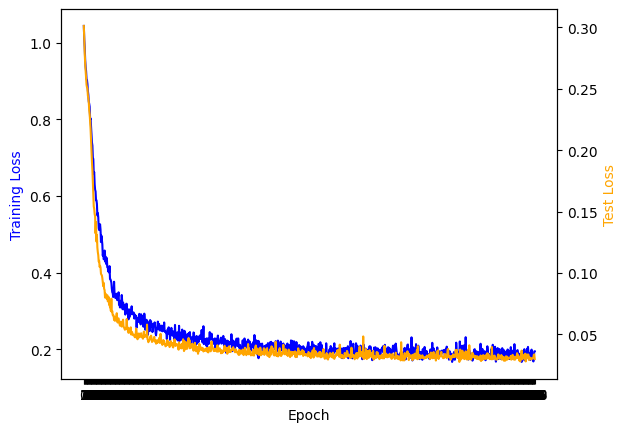

100%|██████████| 1000/1000 [01:02<00:00, 16.09it/s]

 Best Test Loss: 0.027532480657100677


In [32]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 7},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 16, "high": 256, "step": 16, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 1000, plot_output=True)

In [62]:
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

RMSE: 0.011779
MAE: 0.008438



## Optimize

In [57]:
def run_fn(r, p, w, h, t_sio2, dcf, freq):
    feature_array = np.array((r, p, w, h, t_sio2, dcf, freq))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 1)

    return prediction[0]
    # return -(abs(prediction[0] - 1.0)**2)

In [55]:
method = tdd.MethodBayOpt(
    initial_iter=500,
    n_iter=100,
    acq_func='ucb',
    kappa=10,
    xi=0.9,
    seed=1,
)

predict_parameters = parameters + [tdd.ParameterFloat(name="freq", span=(freq, freq))]

output_dir = "/home/matt/Documents/Flexcompute/mmi/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=predict_parameters,
    task_name="bullseye_predict_1",
    folder_name="BSV1",
    path_dir=output_dir,
)

In [58]:
predict_results = design_space.run(run_fn, verbose=True)
predict_df = predict_results.to_dataframe()

14:22:46 BST Best Fit from Initial Solutions: 0.15                              
             

14:23:53 BST Best Result: 0.149723619222641                                     
             Best Parameters: dcf: 2.5012486383503507 freq: 399723277333333.3 h:
             0.4018659239678374 p: 0.5028693680910232 r: 0.4200992362840354     
             t_sio2: 0.5545800413252 w: 0.21644457338081124                     
             

In [59]:
import tidy3d.web as web
best_params = predict_results.optimizer.max['params']
del best_params["freq"]
best_params["tsio2"] = best_params["t_sio2"]
del best_params["t_sio2"]
sim = get_simulation(**best_params)
sim_data = web.run(sim, task_name="best_predicted")

14:31:37 BST WARNING: Mode monitor 'mode_fiber' has a large number (2.60e+05) of
             grid points. This can lead to solver slow-down and increased cost. 
             Consider making the size of the component smaller, as long as the  
             modes of interest decay by the plane boundaries.                   

             Created task 'best_predicted' with task_id                         
             'fdve-071bd103-1629-4c6d-bcff-218eba69faa5' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=68975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=20416;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\taskId]8;;\]8;id=68975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\=]8;;\]8;id=291261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\fdve]8;;\]8;id=68975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\-071bd103-162]8;;\
             ]8;id=68975;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\9-4c6d-bcff-218eba69faa5']8;;\.

Output()

14:31:40 BST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

14:31:56 BST status = preprocess

14:31:57 BST Maximum FlexCredit cost: 0.510. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

14:31:58 BST running solver

Output()

14:32:32 BST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

14:33:05 BST status = success

             View simulation result at                                          
             ]8;id=426017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=695495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\taskId]8;;\]8;id=426017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\=]8;;\]8;id=425205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\fdve]8;;\]8;id=426017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\-071bd103-162]8;;\
             ]8;id=426017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-071bd103-1629-4c6d-bcff-218eba69faa5\9-4c6d-bcff-218eba69faa5']8;;\.

Output()

14:33:08 BST loading simulation from simulation_data.hdf5

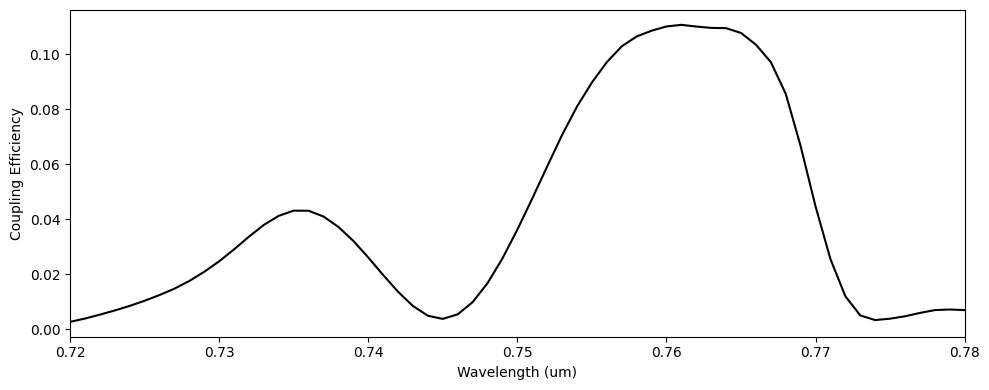

In [60]:
coup_eff = get_coupling_eff(sim_data)

f, ax1 = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
plt.show()